# Discontinuity Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## Kernel weighted RD

In [2]:
class Kernels:
    def __init__(self):
        pass
        

    # Triangular kernel
    def triangular_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (1 - np.abs(R - c) / h)
    
    # Epanechnikov kernel
    def epanechnikov_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (3/4) * (1 - ((R - c) / h) ** 2)
    

# Load the Data

In [3]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328653, 143)

In [26]:
# Print column names
print(df.columns.tolist())

['id', 'photo_key', 'photo_full', 'photo_ed', 'photo_med', 'photo_little', 'photo_small', 'photo_thumb', 'photo_1024x576', 'photo_1536x864', 'name', 'blurb', 'goal', 'pledged', 'state', 'slug', 'disable_communication', 'country', 'country_displayable_name', 'currency', 'currency_symbol', 'currency_trailing_code', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'staff_pick', 'is_starrable', 'backers_count', 'static_usd_rate', 'usd_pledged', 'converted_pledged_amount', 'fx_rate', 'usd_exchange_rate', 'current_currency', 'usd_type', 'creator_name', 'creator_slug', 'creator_is_registered', 'creator_is_email_verified', 'creator_chosen_currency', 'creator_is_superbacker', 'creator_avatar_thumb', 'creator_avatar_small', 'creator_avatar_medium', 'creator_urls_web_user', 'creator_urls_api_user', 'location_id', 'location_name', 'location_slug', 'location_short_name', 'location_displayable_name', 'location_localized_name', 'location_country', 'location_state', 'location_type', 'locat

In [4]:
# Calculate the dollars to goal
df['dollars_to_goal'] = df['pledged']  - df['goal']

# Key Statistics

In [43]:
# Check success next statistics
df[['goal', 'pledged', 'dollars_to_goal', 'staff_pick', 'backers_count']].describe()

,goal,pledged,dollars_to_goal,staff_pick,backers_count
count,3.286530e+05,3.286530e+05,3.286530e+05,321986.000000,328653.000000
mean,5.426921e+04,3.054419e+04,-2.372501e+04,0.116878,128.253273
std,2.092902e+06,1.319432e+06,2.364725e+06,0.321275,899.636542
min,1.000000e+00,0.000000e+00,-9.999999e+08,0.000000,0.000000
25%,2.000000e+03,7.600000e+01,-6.998000e+03,0.000000,3.000000
50%,5.000000e+03,1.286000e+03,0.000000e+00,0.000000,21.000000
75%,1.500000e+04,6.511110e+03,6.650000e+02,0.000000,77.000000
max,1.000000e+09,4.816218e+08,4.278133e+08,1.000000,185341.000000


In [6]:
# Replace nas with 0
filled_df = df.copy()
filled_df = filled_df['success_next'].fillna(0)

In [44]:
cutoff = 0
bandwidth = 10000
bin_size = 20

# Filter out the outliers
plotting_df = df.copy()
plotting_df = plotting_df[(plotting_df['dollars_to_goal'] <= bandwidth) & (plotting_df['dollars_to_goal'] >= -bandwidth)]

# Split data into left and right of the cutoff
left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

# Bin each subset separately
left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)

# Aggregate the binned data for each subset
left_binned_data = left_df.groupby('dollars_to_goal_binned', observed=False).agg({
    'success_next': 'mean',
    'goal': 'mean',
    'backers_count': 'mean',
    'staff_pick': 'mean',
    'prelaunch_activated': 'mean',
    'dollars_to_goal': 'size'  # Counts the number of observations in each bin
}).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
right_binned_data = right_df.groupby('dollars_to_goal_binned', observed=False).agg({
    'success_next': 'mean',
    'goal': 'mean',
    'backers_count': 'mean',
    'staff_pick': 'mean',
    'prelaunch_activated': 'mean',
    'dollars_to_goal': 'size'  # Counts the number of observations in each bin
}).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

# Add a midpoint for each bin for both left and right data
left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

# Combine the binned data for both sides of the cutoff
plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_57212\2535684319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_57212\2535684319.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


In [45]:
# Describe success_next
plotting_df


,dollars_to_goal_binned,success_next,goal,backers_count,staff_pick,prelaunch_activated,n_obs,dollars_to_goal
0,"(-10010.0, -9500.01]",0.064748,10208.373514,4.668865,0.011067,0.074850,8341,-9755.005
1,"(-9500.01, -9000.02]",0.340659,10705.535679,19.865591,0.050275,0.144970,1488,-9250.015
2,"(-9000.02, -8500.03]",0.237288,10234.685288,18.805628,0.050802,0.136054,1528,-8750.025
3,"(-8500.03, -8000.04]",0.243243,9998.231165,22.642732,0.049239,0.141199,1142,-8250.035
4,"(-8000.04, -7500.05]",0.219653,8865.928239,13.072061,0.028854,0.112500,2373,-7750.045
5,"(-7500.05, -7000.06]",0.239130,8455.731659,14.542364,0.050989,0.098324,1971,-7250.055
6,"(-7000.06, -6500.07]",0.202532,7814.457492,14.079966,0.034587,0.117806,2376,-6750.065
7,"(-6500.07, -6000.08]",0.358974,7797.148714,19.199612,0.046327,0.122253,1548,-6250.075
8,"(-6000.08, -5500.09]",0.194872,6684.510525,12.071304,0.033535,0.105495,2875,-5750.085
9,"(-5500.09, -5000.1]",0.209459,6505.293843,17.102144,0.050376,0.120192,1772,-5250.095


## Plot Next Project Success by Dollars to Goal

Text(0.5, 1.0, 'Probability of Next Project Success by Dollars to Goal')

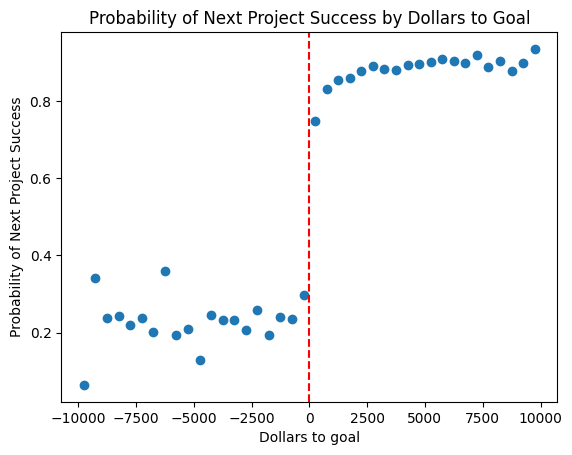

In [46]:
plt.figure()
plt.plot(plotting_df['dollars_to_goal'], plotting_df['success_next'], 'o')
plt.axvline(x=cutoff, color='r', linestyle='--')
plt.xlabel('Dollars to goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Probability of Next Project Success by Dollars to Goal')

# Effect of First Kickstarter on Next Kickstarter

## Regression Variables

In [47]:
# Create threshold Variable
df = df.assign(threshold = (df['dollars_to_goal'] > 0).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)

# Calculate the dollars to goal times threshold
df['dollars_to_goal*threshold'] = np.abs(df['dollars_to_goal'] * df['threshold'])

## Naive Model

In [48]:
model = smf.wls('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', df).fit()

model.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2288,0.003,69.675,0.000,0.222,0.235
dollars_to_goal,3.999e-09,1.66e-09,2.413,0.016,7.5e-10,7.25e-09
threshold,0.6125,0.004,156.068,0.000,0.605,0.620
dollars_to_goal:threshold,6.804e-09,3.05e-09,2.231,0.026,8.27e-10,1.28e-08


Text(0.5, 1.0, 'Regression Discontinuity')

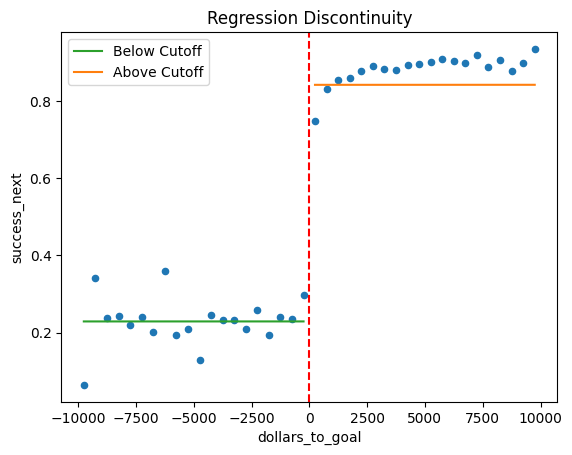

In [49]:
# Remove outliers
ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = {"dollars_to_goal": plotting_df['dollars_to_goal'].values, "threshold": plotting_df['threshold'].values, "dollars_to_goal:threshold": plotting_df['dollars_to_goal*threshold'].values}
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
left_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C2', ax = ax, label = 'Below Cutoff')
right_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C1', ax = ax, label = 'Above Cutoff')
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.title('Regression Discontinuity')

In [50]:
plotting_df

,dollars_to_goal_binned,success_next,goal,backers_count,staff_pick,prelaunch_activated,n_obs,dollars_to_goal,threshold,dollars_to_goal*threshold,predictions
0,"(-10010.0, -9500.01]",0.064748,10208.373514,4.668865,0.011067,0.074850,8341,-9755.005,0,-0.0,0.228747
1,"(-9500.01, -9000.02]",0.340659,10705.535679,19.865591,0.050275,0.144970,1488,-9250.015,0,-0.0,0.228749
2,"(-9000.02, -8500.03]",0.237288,10234.685288,18.805628,0.050802,0.136054,1528,-8750.025,0,-0.0,0.228751
3,"(-8500.03, -8000.04]",0.243243,9998.231165,22.642732,0.049239,0.141199,1142,-8250.035,0,-0.0,0.228753
4,"(-8000.04, -7500.05]",0.219653,8865.928239,13.072061,0.028854,0.112500,2373,-7750.045,0,-0.0,0.228755
5,"(-7500.05, -7000.06]",0.239130,8455.731659,14.542364,0.050989,0.098324,1971,-7250.055,0,-0.0,0.228757
6,"(-7000.06, -6500.07]",0.202532,7814.457492,14.079966,0.034587,0.117806,2376,-6750.065,0,-0.0,0.228759
7,"(-6500.07, -6000.08]",0.358974,7797.148714,19.199612,0.046327,0.122253,1548,-6250.075,0,-0.0,0.228761
8,"(-6000.08, -5500.09]",0.194872,6684.510525,12.071304,0.033535,0.105495,2875,-5750.085,0,-0.0,0.228763
9,"(-5500.09, -5000.1]",0.209459,6505.293843,17.102144,0.050376,0.120192,1772,-5250.095,0,-0.0,0.228765


## RD with Kernel

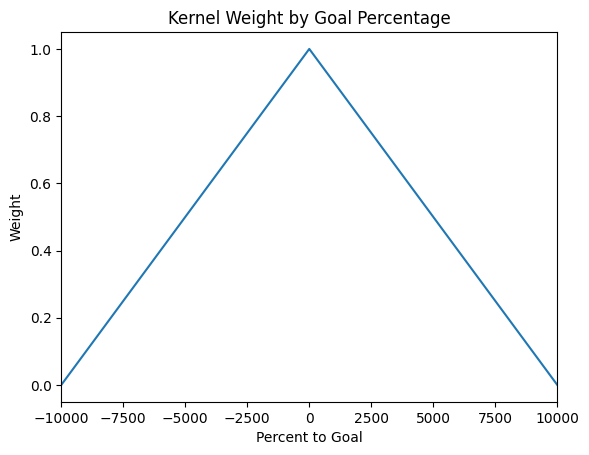

In [51]:
plt.plot(sorted(df["dollars_to_goal"]), Kernels.triangular_kernel(df["dollars_to_goal"], c=cutoff, h=bandwidth), label="Triangular Kernel")
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-bandwidth, bandwidth)
plt.title("Kernel Weight by Goal Percentage");

In [52]:
model1 = smf.wls('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', df, weights = Kernels.triangular_kernel(R = df['dollars_to_goal'], c = cutoff, h = bandwidth)).fit()

model1.summary().tables[1]


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3408,0.006,61.735,0.000,0.330,0.352
dollars_to_goal,2.859e-05,2.08e-06,13.765,0.000,2.45e-05,3.27e-05
threshold,0.4299,0.006,69.925,0.000,0.418,0.442
dollars_to_goal:threshold,3.253e-06,2.56e-06,1.273,0.203,-1.76e-06,8.26e-06


Text(0.5, 1.0, 'Regression Discontinuity')

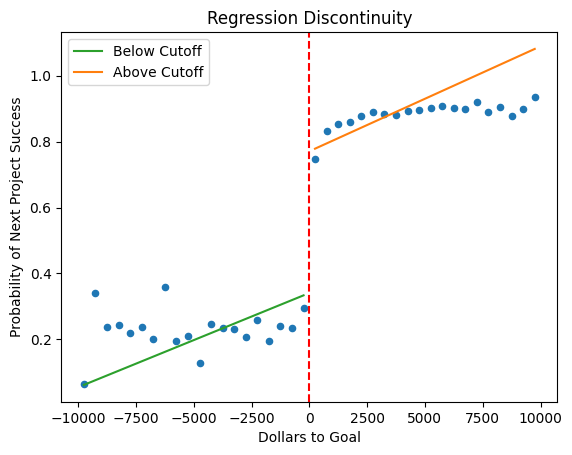

In [53]:
# Remove outliers
ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = {"dollars_to_goal": plotting_df['dollars_to_goal'].values, "threshold": plotting_df['threshold'].values, "dollars_to_goal:threshold": plotting_df['dollars_to_goal*threshold'].values}
plotting_df['predictions'] = model1.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
left_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C2', ax = ax, label = 'Below Cutoff')
right_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C1', ax = ax, label = 'Above Cutoff')
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.xlabel('Dollars to Goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Regression Discontinuity')

## RD with Controls and Weights

In [54]:
model = smf.wls('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold + goal + backers_count + staff_pick + prelaunch_activated', df, weights = Kernels.triangular_kernel(R = df['dollars_to_goal'], c = cutoff, h = bandwidth)).fit()

model.summary().tables[1]


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3926,0.007,58.786,0.000,0.379,0.406
dollars_to_goal,2.876e-05,2.58e-06,11.162,0.000,2.37e-05,3.38e-05
threshold,0.3336,0.008,44.177,0.000,0.319,0.348
dollars_to_goal:threshold,-2.344e-05,3.3e-06,-7.098,0.000,-2.99e-05,-1.7e-05
goal,-8.931e-07,2.88e-07,-3.099,0.002,-1.46e-06,-3.28e-07
backers_count,0.0004,3.28e-05,12.842,0.000,0.000,0.000
staff_pick,0.0570,0.007,8.363,0.000,0.044,0.070
prelaunch_activated,0.1423,0.006,25.727,0.000,0.131,0.153


Text(0.5, 1.0, 'Regression Discontinuity')

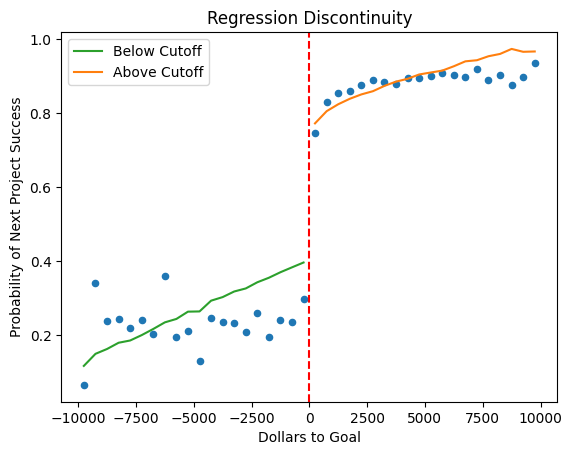

In [55]:
# Remove outliers
ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = {"dollars_to_goal": plotting_df['dollars_to_goal'].values, 
             "threshold": plotting_df['threshold'].values, 
             "dollars_to_goal:threshold": plotting_df['dollars_to_goal*threshold'].values, 
             "goal": plotting_df['goal'].values,
             "backers_count": plotting_df['backers_count'].values,
             "staff_pick": plotting_df['staff_pick'].values,
             "prelaunch_activated": plotting_df['prelaunch_activated'].values}

plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
left_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C2', ax = ax, label = 'Below Cutoff')
right_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C1', ax = ax, label = 'Above Cutoff')
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.xlabel('Dollars to Goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Regression Discontinuity')